In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import src.utils.data_utils as data_utils

# Check if LaTeX is available, if not we don't import the plot_config module
latex_available = False
try:
    plt.rcParams['text.usetex'] = True
    plt.text(0, 0, "Test", fontsize=12)
    latex_available = True
    plt.close()
except Exception as e:
    print("LaTeX is not available. Error:", e)
finally:
    plt.rcParams['text.usetex'] = False

# Import the plot_config module if LaTeX is available
if latex_available:
    import src.utils.plot_config

%matplotlib inline

In [2]:
# Download the data files
datasets = [ 
    # ("https://zenodo.org/records/4650046/files/_raw_df_channels.tsv.gz?download=1", "channels.tsv.gz"), # 6.0 MB
    # ("https://zenodo.org/records/4650046/files/yt_metadata_en.jsonl.gz?download=1", "yt_metadata.jsonl.gz"), # 13.6 GB
]

data_utils.get_data(datasets)

# Classification using keywords

## Chunk Processing

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

The following cell tests the `preprocess_collaborations` function (defined in data_utils.py).



**Comment on methodology:** 
- The detection of collaborations is based on the presence of specific keywords in the video title, by default the keywords are:`feat`, `ft`, `featuring`, `x`, `w/`, `ft.`.
- This approach is really simple and may not be accurate in all cases. We could have considered other keywords such as `with`, `and`, `&`, etc. but this would yield a greater number of false positives (this has been tested). 
- With this approach, we may have many false negatives, i.e. collaborations that are not detected.
- We also tested the detection of collaborations using a zero-shot model (see the cell at the end of this notebook). This approach revealed that the zero-shot model is not accurate enough to be used in this context (and it is also much slower).

</div>

In [3]:
# Load a chunk of data
# data_file = 'data/yt_metadata.jsonl.gz'
# test_data = pd.read_json(data_file, lines=True, compression="gzip", nrows=100_000)

# Preprocess the data
# processed_df = data_utils.preprocess_collaborations(test_data)
# processed_df.sample(3)

## Process the whole dataset

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

The following cells process the whole dataset and saves the results to new files.

This should be done only once, as it may take a long time to run.

</div>

In [4]:
# Define the input and output paths
data_file = 'data/yt_metadata.jsonl.gz'
chunk_size = 100_000

In [5]:
# Process the metadata to only keep the Entertainment and Music entries
# data_utils.process_data(data_file, chunk_size, data_utils.filter_categories, output_path='data/yt_metadata_filtered.jsonl.gz')

In [6]:
# Process the collaboration data (this may take ~30 minutes) 
# data_utils.process_data("data/yt_metadata_filtered.jsonl.gz", chunk_size, data_utils.preprocess_collaborations, output_path='data/collaborations.jsonl.gz')

In [7]:
# Process the number of videos per channel_id
# data_utils.process_video_counts(data_file, chunk_size, output_path='data/video_counts.jsonl.gz')

## Open the processed data

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

In the cells below, we open the processed data and display the first few rows. Then, we display the number of collaborations in each category.

In previous analysis, we found that the total number of Music videos is ~ 8.2 M and the total number of Entertainment videos is ~ 12.3 M, we can therefore compare the fraction of collaborations in each category. 
</div>

In [8]:
# Load the processed data and display the first few rows
df_collaborations = pd.read_json('data/collaborations.jsonl.gz', lines=True, compression='gzip')
df_collaborations.sample(3)

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date
873011,Music,SMALL BOWL #HHS21 (5” x 2.5”) 440 gm,This fine Tibetan Singing Bowl\nis available f...,"Tibetan Singing Bowl,Meditation,Gong,Himalayan...",690,28,0,UC1jtAq_bP3reGKykkbW26ww,2018-11-05 00:00:00
125710,Music,Lil Durk - All She Want Ft Cashout Signed To T...,We are THE #1 Source for West Coast Rap Music!...,"la rappers 2016,california rappers list,los an...",10818,65,2,UClTvGbHJSUQusgu7FigAZCQ,2013-08-20 00:00:00
776266,Music,Skizzy Jay Ft. NJ Fuego - Late Nights (Prod. F...,Skizzy Jay Ft. NJ Fuego - Late Nights (Prod. F...,"skizzy jay nj fuego late nights,skizzy jay lat...",3710,141,3,UC7VvoTNKBTIK6a8R_NX8QVQ,2018-12-02 00:00:00


In [9]:
# Display the number of collaborations in each category
counts = df_collaborations.value_counts('categories')
print(f"Fraction of collaborations in the Music category: {100 * counts['Music'] / 8305003:.1f} %")
print(f"Fraction of collaborations in the Entertainment category: {100 * counts['Entertainment'] / 12276397:.1f} %")

Fraction of collaborations in the Music category: 8.5 %
Fraction of collaborations in the Entertainment category: 1.8 %


<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Comment:** with our collaboration detection technique, there are more collaborations in the Music category compared to the Entertainment category.

</div>

In [10]:
# Open and read the file
df_video_counts = pd.read_json('data/video_counts.jsonl.gz', lines=True, compression='gzip')
df_video_counts.sample(3)

,channel_id,video_count
125994,UC2-V0rEZF_uxDSUxeRxov5Q,453
32462,UCeXCwXqfZxeHxP2v8Mz7Kng,563
66106,UCR6U2-2nrH3ef87phmLr84w,120


## Are collaborations more prone to greater viewership and engagement? 

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

We can start by studying the distribution of the number of views, likes, and dislikes for collaborations in each category.

We can then 
1. Compare the distributions for collaborations between the Music and Entertainment categories.
2. Compare the distributions for collaborations and non-collaborations in each category. 

Point 1. will help us understand if one category has the upper hand when it comes to collaborations. 

Point 2. will help us understand if collaborations are more successful than non-collaborations in each category.

</div>

In [11]:
# We start by creating a dataframe per category
df_music = df_collaborations[df_collaborations['categories'] == 'Music'].copy()
df_entertainment = df_collaborations[df_collaborations['categories'] == 'Entertainment'].copy()

In [12]:
df_music.sample(3)

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date
141656,Music,[FREE] Trap Beat | Zaytoven Type Beat | Future...,💰Download | Purchase (untagged):\n💻 Website: h...,"zaytoven,future,type beat 2019,type beat,trap,...",31388,542,19,UCkMbXNfTDkLAaq2SrK5JHSg,2019-01-04 00:00:00
483936,Music,Bogdan feat Dr Slim - Time To Move (Official...,Check out the official music video for Misty's...,"Bogdan,feat,Dr,Slim,Time,To,Move,Official,Video",36155,366,49,UCOzSFwjkQD6oQohRf4D6ndA,2012-07-18 00:00:00
519741,Music,Franky Nuts - Bring It On feat. Mikey Ceaser ...,Buy: https://fanlink.to/FNsbk\n\nThe new singl...,"Circus Records,Flux Pavilion,Cookie Monsta,Fun...",3039,188,6,UCN3Qs8QcRcNmn7W-0WHAqgA,2017-02-18 00:00:00


In [13]:
df_entertainment.sample(3)

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date
181831,Entertainment,"LET'S PLAY Pac-Man World (w/commentary), PT. 8...",,,58,0,0,UChvdfjIZChTCf4wr5CV0JSw,2018-02-02 00:00:00
769495,Entertainment,gravity falls bill x dipper - MLP Speedpaint,,,26622,641,63,UC7iqSxdWvmyL1WM18EEe53Q,2017-08-06 00:00:00
481815,Entertainment,Workshop || Swish Swish || Katy Pery ft. Nicki...,WATCH ON YOUR MOBILE PHONES NOW:\nhttps://yout...,"swish swish dance,swish swish,dance on swish s...",6259,154,7,UCP8eJORQClFsWOZH4BcojEQ,2017-09-19 00:00:00


### Distribution of views, likes, and dislikes for Music and Entertainment collaborations

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

We start by plotting the distribution of views, likes, and dislikes for the Music and Entertainment categories separately.

(Uncomment the cell below to run it, the results are directly compared below).

</div>

In [14]:
# Distributions for the Music category
# data_utils.plot_category_distribution(df_data=df_music,
#                                       columns=["view_count", "like_count", "dislike_count"],
#                                       category="Music",
#                                       x_logs=[True, True, True],
#                                       y_logs=[False, False, True],
#                                       kind="hist",
#                                       print_summary=True)

In [15]:
# Distributions for the Entertainment category
# data_utils.plot_category_distribution(df_data=df_entertainment,
#                                       columns=["view_count", "like_count", "dislike_count"],
#                                       category="Entertainment",
#                                       x_logs=[True, True, True],
#                                       y_logs=[False, False, True],
#                                       kind="hist",
#                                       print_summary=True)

### Comparison of views, likes, and dislikes between Music and Entertainment collaborations

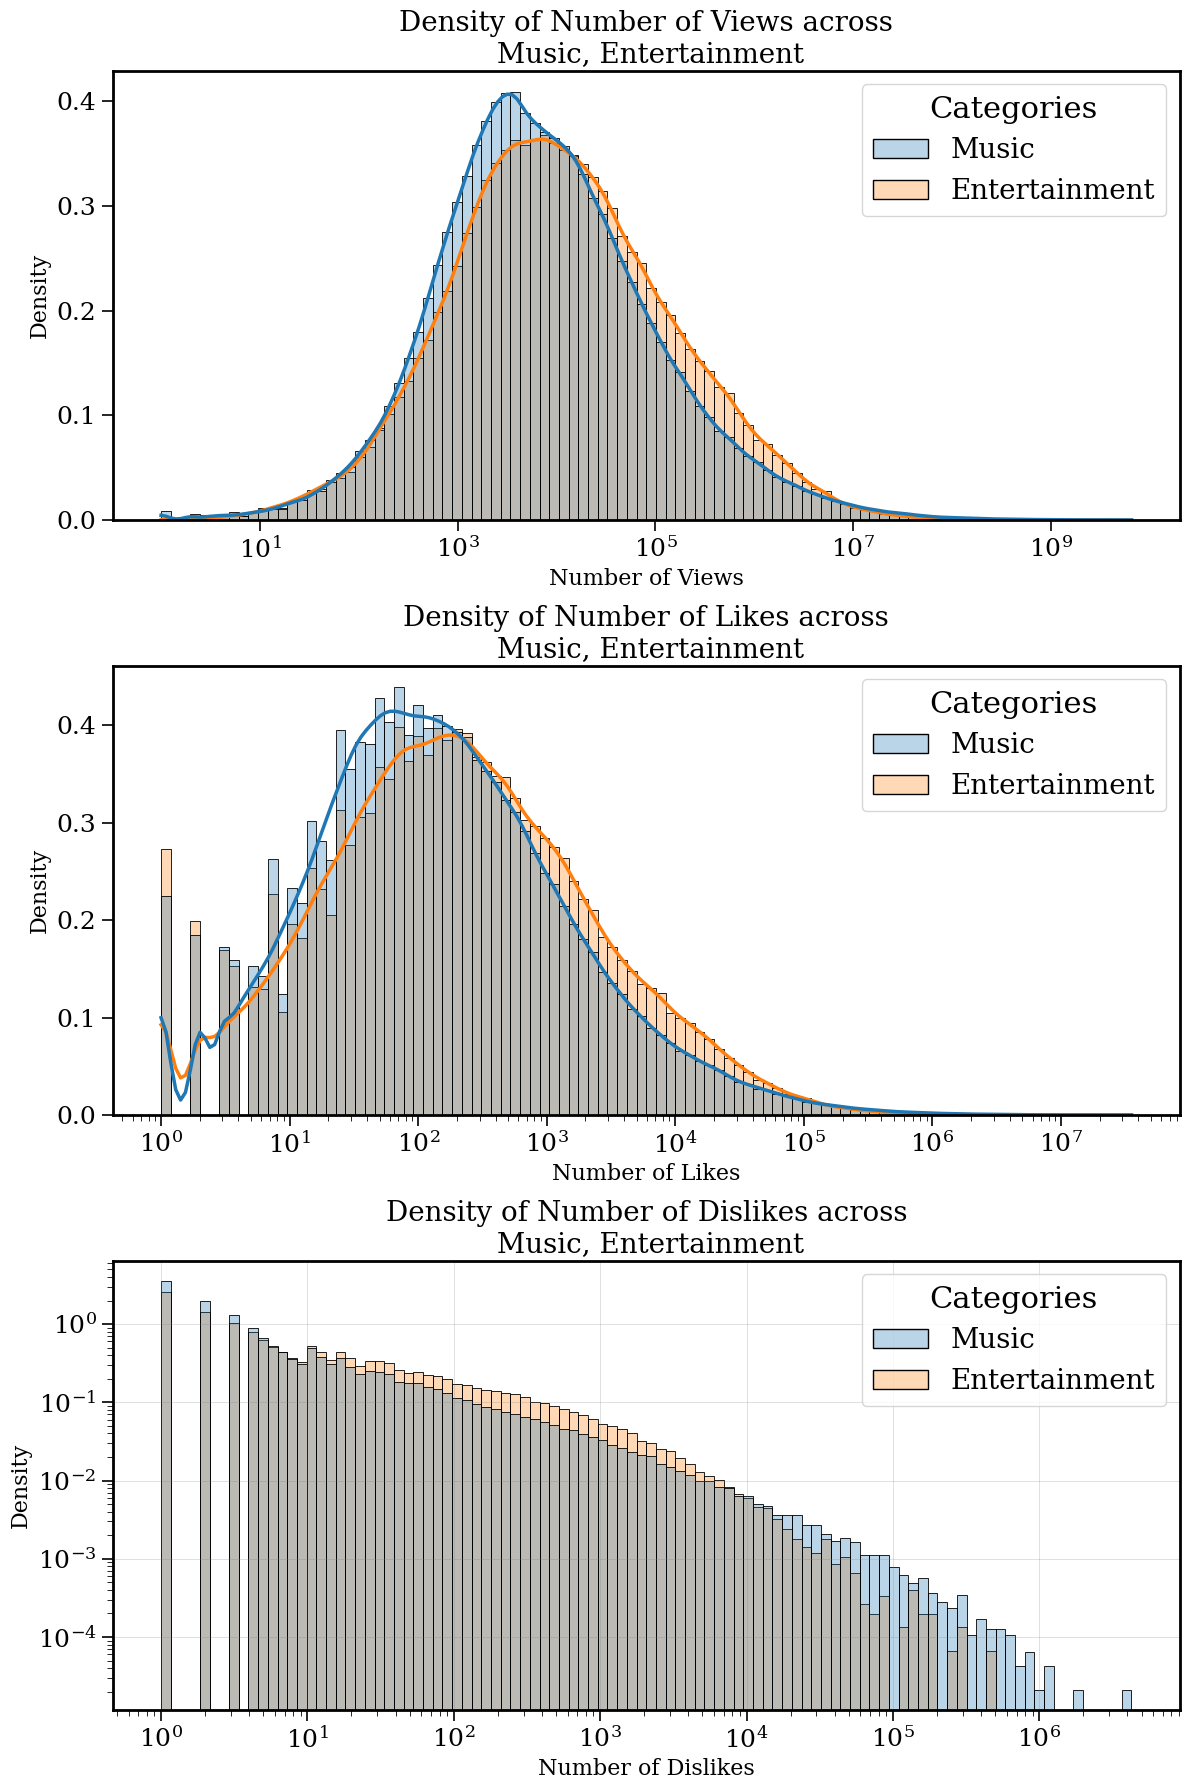

In [16]:
categories = ["Music", "Entertainment"]
data_utils.compare_distribution_across_categories(df_collaborations,
                                                  columns=["view_count", "like_count", "dislike_count"],
                                                  categories=categories,
                                                  hue="categories",
                                                  x_logs=[True, True, True],
                                                  y_logs=[False, False, True],
                                                  kind="hist",
                                                  marker_only=False, 
                                                  density=True)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Some comments:**

- The distribution of views for the Music category seems to be slightly skewed to the left compared to the Entertainment category. 

- A similar observation can be made for the distribution of likes. 

- The distribution of dislikes seems almost power-law distributed for the Music category. The Entertainment distribution is a bit more "rounded". 

In each case, since we log-transformed the x-axis, we can look at the geometric mean to compare the two categories.

</div>

In [17]:
# Compute both geometric and arithmetic means for each category
columns = ["view_count", "like_count", "dislike_count"]

music_gmeans = {col: data_utils.geometric_mean(df_music[col]) for col in columns}
entertainment_gmeans = {col: data_utils.geometric_mean(df_entertainment[col]) for col in columns}

music_means = {col: df_music[col].mean() for col in columns}
entertainment_means = {col: df_entertainment[col].mean() for col in columns}

# Display the comparison in a unified table
print("Comparison of geometric and arithmetic Means for Music and Entertainment Categories:\n")
print(f"{'Metric':<20} {'Music (Geometric)':<20} {'Entertainment (Geometric)':<30} {'Music (Arithmetic)':<20} {'Entertainment (Arithmetic)':<20}")
print("-" * 120)

for col in columns:
    music_geo = music_gmeans[col]
    music_arith = music_means[col]
    ent_geo = entertainment_gmeans[col]
    ent_arith = entertainment_means[col]
    print(f"{col:<20} {music_geo:<20.2f} {ent_geo:<30.2f} {music_arith:<20.2f} {ent_arith:<20.2f}")

Comparison of geometric and arithmetic Means for Music and Entertainment Categories:

Metric               Music (Geometric)    Entertainment (Geometric)      Music (Arithmetic)   Entertainment (Arithmetic)
------------------------------------------------------------------------------------------------------------------------
view_count           7716.97              10885.06                       681441.02            311771.52           
like_count           145.24               194.23                         5114.49              3640.42             
dislike_count        6.58                 10.81                          228.10               166.95              


<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Some comments**

- When looking at the geometric means, the Entertainment category seems to have the upper hand in terms of views and likes (as can be seen from the distributions).
- Interestingly, when looking at the arithmetic means (that might be ill-defined), the Music category seems to have higher values for views and likes. This is probably due to the presence of **stronger outliers in the Music category**. 

</div>

## Which category exhibits more collaborations? 

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

For each channel, we will compute a "collaboration ratio" defined as 
$$
\text{collaboration ratio} = \frac{\text{number of collaboration videos}}{\text{total number of videos}}. 
$$

This will allow us to group the collaborations by category and compare the distribution of the collaboration ratio between the Music and Entertainment categories. 

**Method**: 
1. Add a new column to the collaborations data that counts the number of collaborations for each channel
2. Add the total number of videos for each channel to the collaborations data
3. Merge the collaborations data with the channels data to get the channel names and other information (that will be useful for other analysis)
4. Compute the collaboration ratio for each channel and category
5. Compare the distribution of the collaboration ratio between the Music and Entertainment categories

</div>


In [18]:
# 1. 
# Add a new column to the collaborations data that counts the number of collaborations for each channel
df_collaborations['collaborations_count'] = df_collaborations.groupby('channel_id')['channel_id'].transform('count')

print(f"Number of unique channels in the collaborations data: {df_collaborations['channel_id'].nunique()}")
df_collaborations.sample(3)

Number of unique channels in the collaborations data: 36966


,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date,collaborations_count
368933,Music,Little Dee - Give it all up (featuring Steelo),Free mixtape download: http://grimehq.com/down...,,96,0,0,UCxEujlr3K1xXK-XVVDNpJ6Q,2013-11-28 00:00:00,997
250590,Music,"Cee ElAssaad, Jackie Queens - All On You (Hype...",♪ ♫ ♬ Afro House is Our Religion ♪ ♫ ♬\n◆ If Y...,"mr afro deep,mr afro deep 2019,mr afro deep pl...",4054,99,2,UCdWEHBPLvjWHMOwBycNP9Sg,2019-03-06 00:00:00,528
601963,Entertainment,"""My Name Is Kim Kardashian"" (Andrew Caldwell F...",#AndrewCaldwell #UsherBoard\n#TheUsherBoard\n\...,"funny,comedy,starbucks,starbucks pink drink,st...",7259,248,14,UCHu0AKlaUgrwfyQLppcIyuw,2019-08-24 00:00:00,13


In [19]:
# 2. 
# Merge the collaborations data with the video counts data
df_collaborations = pd.merge(df_collaborations, df_video_counts, on='channel_id', how='left')
df_collaborations.sample(3)

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date,collaborations_count,video_count
408071,Music,The Brand New Heavies Ft Large Prof Main Sourc...,http://www.deliciousvinyl.com\n\nfrom Heavy Rh...,"acidjazz,funk,soul,main,source,large,professor...",93308,412,3,UCU_yyuylxwwuJ_YqgAGnxFg,2007-11-14 00:00:00,36,349
459518,Music,"Famous Dex - Nervous (Clean) ft. Lil Baby, Ric...","Famous Dex - Nervous (Clean) ft. Lil Baby, Ric...","Famous dex,nervous,clean,lil baby,rich the kid...",31439,392,4,UCR0hxp8EfU7lO4Od52lBIiA,2018-09-21 00:00:00,276,656
439193,Music,Quintino & Outsiders x Shockman - Carnival Up ...,Download:\nhttps://goo.gl/HDywBm\n\nQuintino &...,,3502,108,3,UCwcABAYCKIGuPK1yMFKVeXw,2017-06-26 00:00:00,285,1067


In [20]:
# 3. 
# Open the channels data, filter the Music and Entertainment categories, and drop the join_date column
df_channels = pd.read_csv('data/channels.tsv.gz', sep='\t', compression='gzip')
df_channels = df_channels[df_channels['category_cc'].isin(['Music', 'Entertainment'])]
df_channels = df_channels.drop(columns=['join_date', 'category_cc', 'videos_cc', 'subscriber_rank_sb'], axis=1)
df_channels = df_channels.rename(columns={'channel': 'channel_id'})

print(f"Number of unique channels in the Entertainment and Music categories: {df_channels.shape[0]}")

# Merge the channel names to the collaborations data
df = pd.merge(df_collaborations, df_channels, on='channel_id', how='left')

# Create a new column that calculates the ratio of collaborations to the total number of videos
df['colab_ratio'] = df['collaborations_count'] / df['video_count']

# Reorder the columns
new_order = ['name_cc', 'title', 'view_count', 'like_count', 'dislike_count', 'description', 'tags', 'upload_date', 'subscribers_cc',
             'video_count', 'collaborations_count', 'colab_ratio', 'channel_id', 'categories']

df = df[new_order].copy()
df.sample(3)

Number of unique channels in the Entertainment and Music categories: 55513


,name_cc,title,view_count,like_count,dislike_count,description,tags,upload_date,subscribers_cc,video_count,collaborations_count,colab_ratio,channel_id,categories
889429,Solrac Etnevic,Technotronic [Feat] - MC Eric - This Beat Is T...,45564,586,18,Video Take From Cris Mate YouTube Channel http...,"technotronic,ya kid k,mc eric,this beat is tec...",2017-07-25 00:00:00,456281.0,308,21,0.068182,UC0RKPIqgL98gqKmYlr-V5-A,Music
43653,Toolroom Records,Mark Knight feat. The B.B.n. - The Reason - Ro...,4318,19,0,Mark Knight feat. The B.B.n. - The Reason - Ro...,"Toolroom,Records,Knights,Mark,Knight,Club,Danc...",2010-04-09 00:00:00,324000.0,3094,425,0.137363,UCpiZh3AGeTygzfmUgioOFFg,Music
219202,ZASound,PS DJz – Shona Phantsi ft. Toolz & Tman,12129,91,3,PS DJz - Shona Phantsi ft. Toolz & Tman | #zas...,"zasound,sa,hip,hop,mzansi,music,PS,Djz,Shona,P...",2018-05-02 00:00:00,66600.0,820,305,0.371951,UCf7i4wMNpkloAkQEFfnSPFA,Music


In [21]:
# 4. Collect the collaboration ratio for each channel and category
df_colab_ratio = df.groupby(['channel_id', 'categories'])['colab_ratio'].mean().reset_index()
df_colab_ratio.sample(3)

,channel_id,categories,colab_ratio
22593,UCYkwskRA1ODNA1L2tVMQOUQ,Entertainment,0.017361
11220,UCGi0PQkBJPknPmGsS7ils9A,Music,0.173077
19095,UCTAPBFpeqrgTMaAeSDF3vdA,Music,0.052632


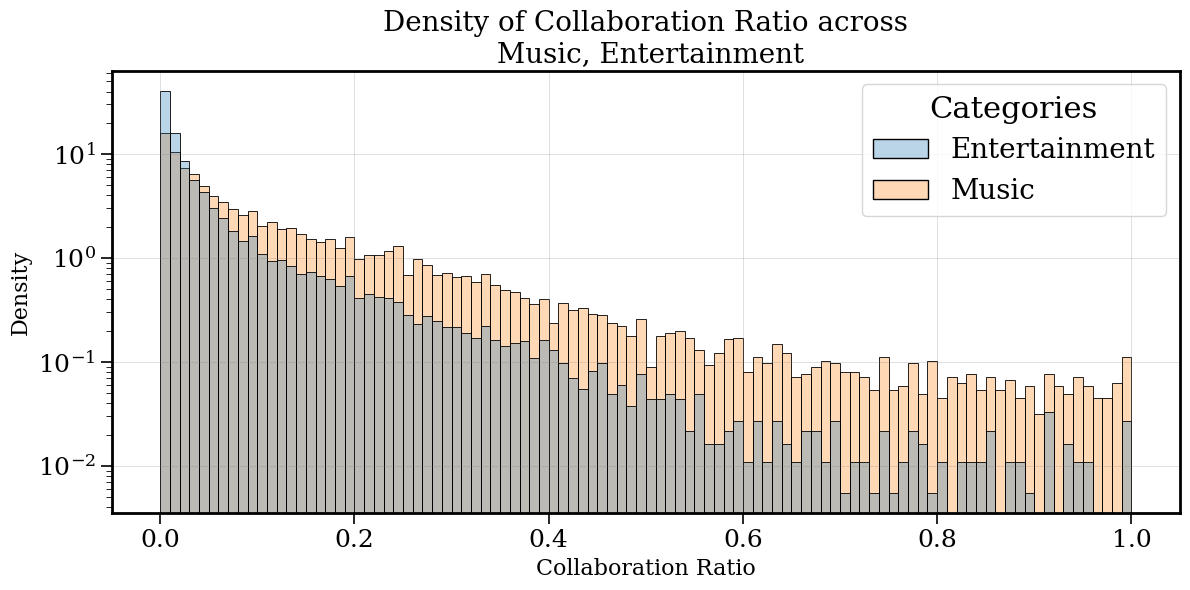

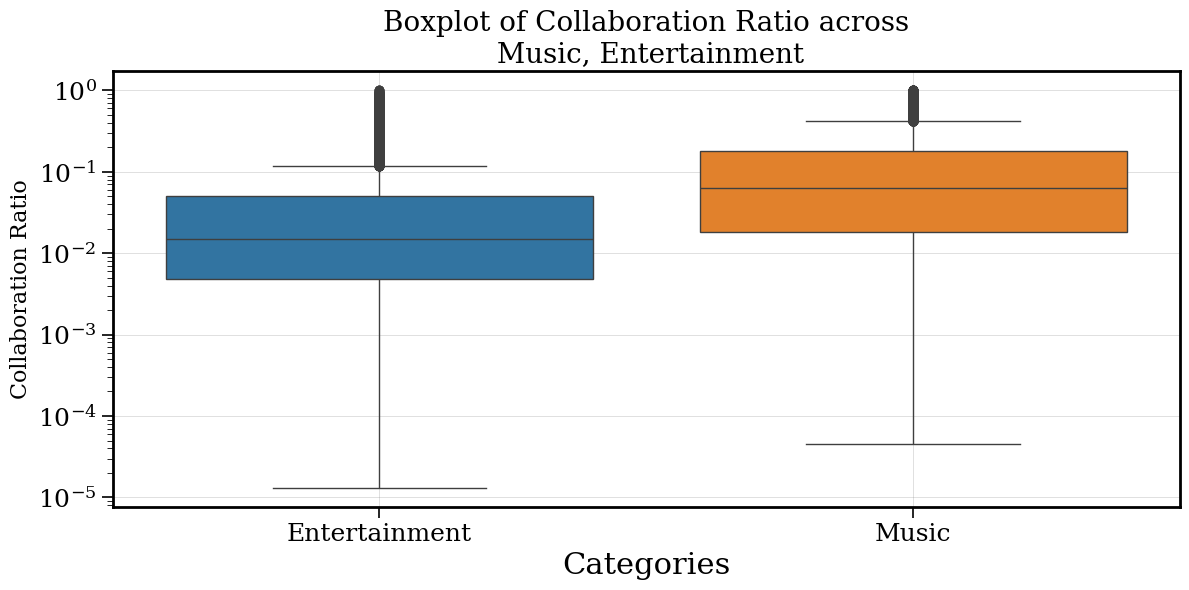

In [22]:
# 5. Comparison of the collaboration ratio between the Music and Entertainment categories
# TODO : Here the colors are interchanged, fix this
categories = ["Music", "Entertainment"]
data_utils.compare_distribution_across_categories(df_colab_ratio,
                                                  columns=["colab_ratio"],
                                                  categories=categories,
                                                  hue="categories",
                                                  x_logs=[False],
                                                  y_logs=[True],
                                                  kind="hist",
                                                  marker_only=False,
                                                  density=True)

data_utils.compare_distribution_across_categories(df_colab_ratio,
                                                  columns=["colab_ratio"],
                                                  categories=categories,
                                                  hue="categories",
                                                  x_logs=[False],
                                                  y_logs=[True],
                                                  kind="boxplot")

In [23]:
combined_desc = pd.DataFrame({
    'Music': df_colab_ratio[df_colab_ratio['categories'] == 'Music']['colab_ratio'].describe(),
    'Entertainment': df_colab_ratio[df_colab_ratio['categories'] == 'Entertainment']['colab_ratio'].describe()
})

combined_desc

,Music,Entertainment
count,22296.000000,18368.000000
mean,0.130323,0.051594
std,0.169132,0.096726
min,0.000045,0.000013
25%,0.018405,0.004796
50%,0.062500,0.015152
75%,0.178701,0.049986
max,1.000000,1.000000


<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Some comments:** 

From the histograms: 
- In both categories, the collaboration ratio seems to be decreasing, i.e. there are more channels with a low collaboration ratio than with a high collaboration ratio.
- The collaboration ratio for the Entertainment category is decaying faster than for the Music category. 

From the boxplot:
- The median collaboration ratio is higher for the Music category, it is greater than the 75th percentile of the Entertainment category.

From the summary statistics:
- The mean and median collaboration ratio are higher for the Music category.
- As seen in the boxplot, the median of the Music category is greater than the 75th percentile of the Entertainment category.

**Conclusion:** Overall, the creators in the Music category seem to have a higher collaboration ratio than the creators in the Entertainment category.
</div>

---

<div style="background-color: #FFC0CB; border-left:3px solid red; padding: 10px; border-radius: 5px;">

Autres idées:

- Possible de faire un test statitstique pour vérifier si la différence des distributions est significative?

</div>


## Evolution of collaborations over time: is there an obvious collaboration strategy? 

<div style="background-color: #FFC0CB; border-left:3px solid red; padding: 10px; border-radius: 5px;">

Par exemple, si on se concentre sur les chaînes de musique et entertainment avec un ratio de collaboration similaire (par exemple 0.2), est-ce qu'une tendance globale pour les deux catégories se dessine ? 
- Est-ce que les chaînes d'entertainment collaborent de plus en plus (peu au début de Youtube et davantage récemment?)  
- Est-ce que la collaboration dans la musique est une "constante" ou bien est-ce qu'il y a aussi une augmentation du nombre de featuring? 

On pourrait comparer la tendance moyenne avec la tendance pour les $N$ chaînes les plus connues et aussi pour les $N$ chaînes les moins connues. Est-ce qu'une stratégie chez les créateurs les plus influents se dessine ? (Peut-être trier les chaines avec un ratio de collaboration plutôt faible car les petites chaines ont probablement pas trop de feats)

</div>


### Grouping by Collaboration Ratio Ranges

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

To begin with, we will group the channels by collaboration ratio ranges. This will allow us to analyze the behaviour of channels with similar collaboration ratios.

For each collaboration ratio range, we analyze the following:
- The number of channels
- The number of videos
- The total, the average and the median number of views
- The total, the average and the median number of likes
- The total, the average and the median number of dislikes
</div>


In [24]:
# Assign a collaboration ratio range to each video
n_bins = 41
colab_ratio_bins = np.linspace(0,1, n_bins)
df['colab_range'] = pd.cut(df['colab_ratio'], bins=colab_ratio_bins, include_lowest=True)

In [25]:
# Get the number of channel by colab_ratio range
stats_music = (df[df["categories"] == "Music"].groupby('colab_range', observed=False)
               .agg(num_videos=('channel_id', 'count'), 
                    num_channels=('channel_id', 'nunique'), 
                    num_views=('view_count', 'sum'), 
                    avg_views=('view_count', 'mean'),
                    med_views=('view_count', 'median'),
                    num_likes=('like_count', 'sum'),
                    avg_likes=('like_count', 'mean'),
                    med_likes=('like_count', 'median'), 
                    num_dislikes=('dislike_count', 'sum'),
                    avg_dislikes=('dislike_count', 'mean'),
                    med_dislikes=('dislike_count', 'median')).reset_index())

stats_entertainment = (df[df["categories"] == "Entertainment"].groupby('colab_range', observed=False)
                       .agg(num_videos=('channel_id', 'count'),
                            num_channels=('channel_id', 'nunique'),
                            num_views=('view_count', 'sum'),
                            avg_views=('view_count', 'mean'),
                            med_views=('view_count', 'median'),
                            num_likes=('like_count', 'sum'),
                            avg_likes=('like_count', 'mean'),
                            med_likes=('like_count', 'median'),
                            num_dislikes=('dislike_count', 'sum'),
                            avg_dislikes=('dislike_count', 'mean'),
                            med_dislikes=('dislike_count', 'median')).reset_index())

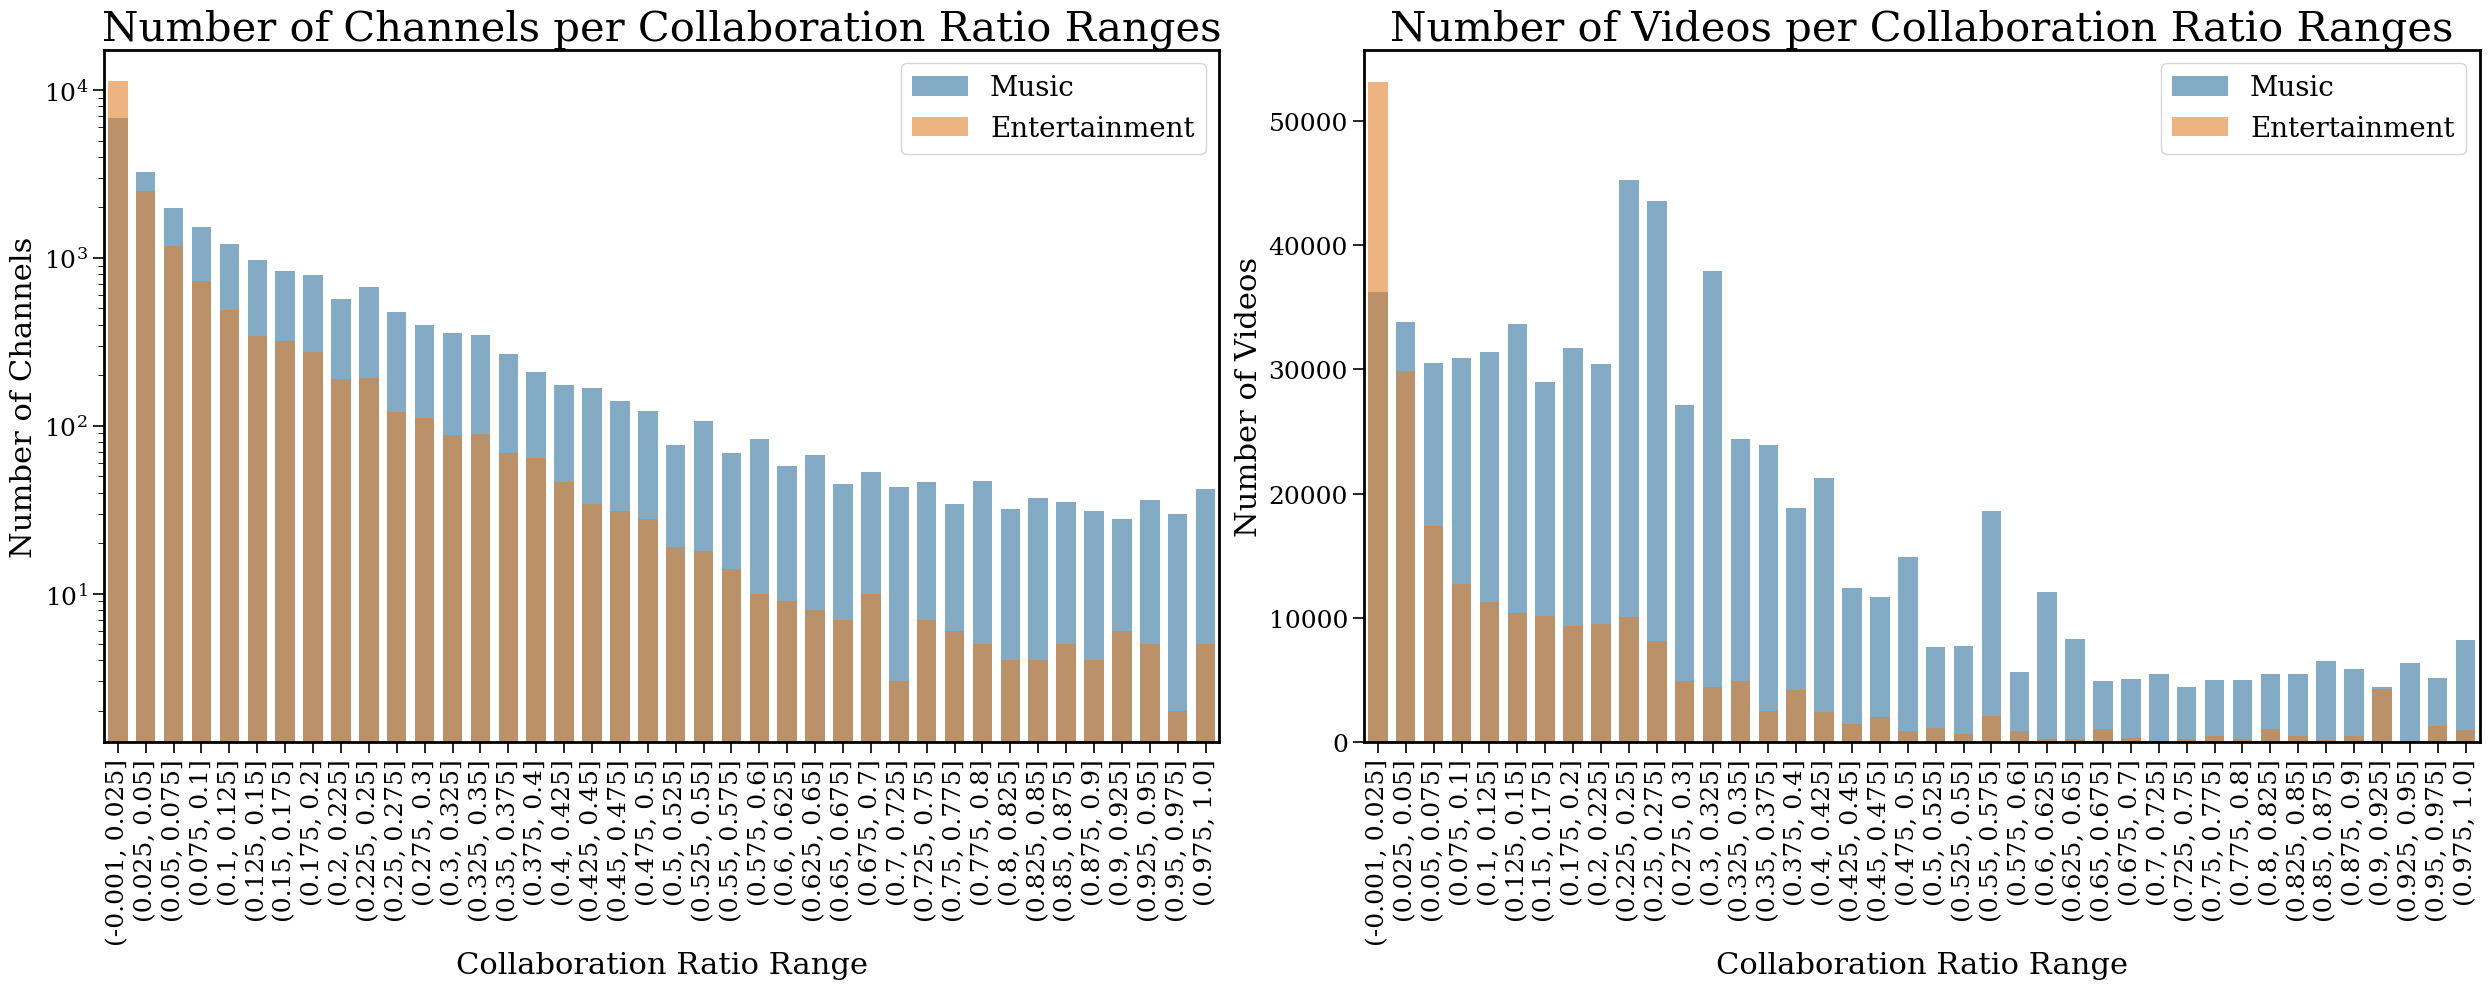

In [26]:
metrics_channels_videos = [("num_channels", "num_channels"), ("num_videos", "num_videos")]
titles_channels_videos = ["Number of Channels per Collaboration Ratio Ranges", "Number of Videos per Collaboration Ratio Ranges"]
ylabels_channels_videos = ["Number of Channels", "Number of Videos"]
ylog = [True, False]

data_utils.plot_collaboration_stats(stats_music, stats_entertainment, metrics_channels_videos, titles_channels_videos, ylabels_channels_videos, figsize=(25,10), ylog=ylog)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Some comments**: 

The plot on the left reproduces a result we already had (the density of the collaboration ratio was already plotted). This plot allowed us to deduce that there are more collaborations in the Music Category overall. 
- It is important to note that **the sample size is really small (<50 channels) in the Entertainment category for collaboration ratios over 0.45, this could bias our analysis**.

The plot on the right shows a strong difference between the Music and Entertainment categories: 
- The Entertainment category has a decline that looks exponential in the number of videos as the collaboration ratio increases. **This suggests that most channels in this category prefer working individually, with very few collaborations**.
- In contrast, the Music category shows a flatter trend for low ratios, with a peak in collaboration ratios between **0.225** and **0.275**. This indicates that moderate levels of collaboration are more common in Music channels, possibly due to the nature of music production (e.g., featuring artists or bands).
</div>

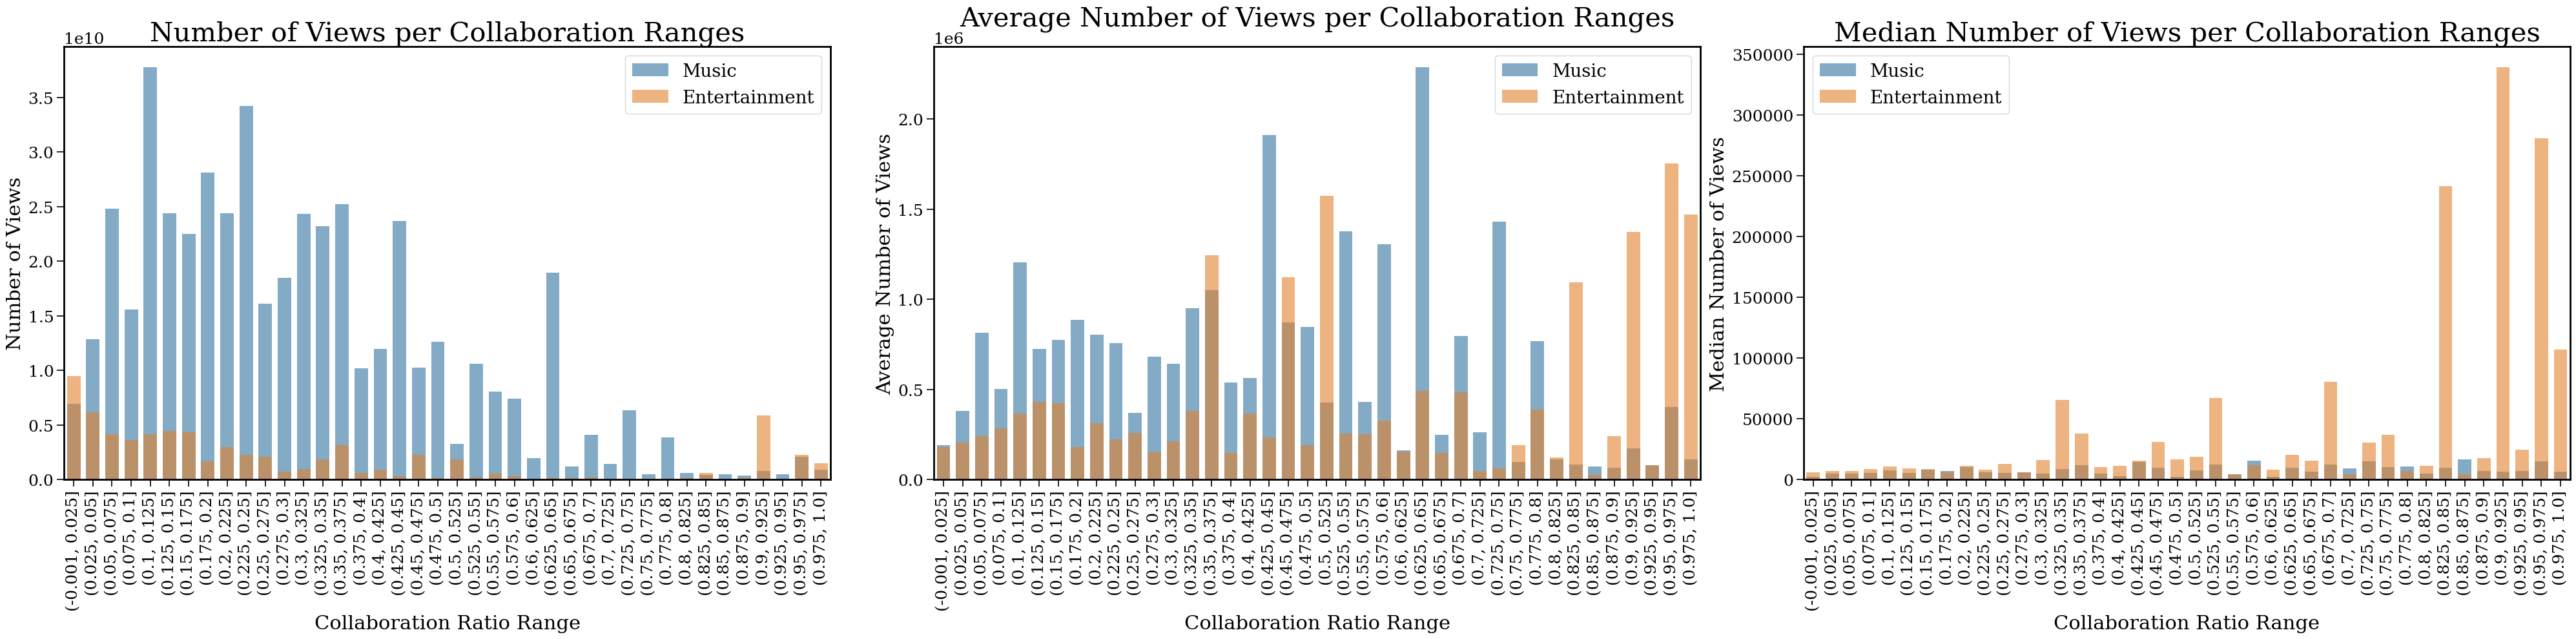

In [27]:
# Define plotting parameters for views
metrics = [("num_views", "num_views"), ("avg_views", "avg_views"), ("med_views", "med_views")]
titles = ["Number of Views per Collaboration Ranges", "Average Number of Views per Collaboration Ranges", "Median Number of Views per Collaboration Ranges"]
ylabels = ["Number of Views", "Average Number of Views", "Median Number of Views"]

# Plot the views statistics vs. collaboration ratio range
data_utils.plot_collaboration_stats(stats_music, stats_entertainment, metrics, titles, ylabels)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Some comments**: 
The plot on the left shows that when looking at the total number of views, Music seems to dominate Entertainment almost all collaboration ratio ranges (this is probably due to the fact that there are many more Music videos in these ranges as seen in the plot above). 
- Interestingly, Entertainment wins on the extremes especially in the range (0.9, 0.925], despite having almost the same number of videos as the Music category in this range (and fewer channels)!  

The plot in the middle displays the average number of views per collaboration videos: Music again has the upper hand in most ranges but is completely far behind for 3 of the 4 highest ranges. This means that for channels that almost always collaborate, those in the Entertainment category are more engaging. 
- For the Entertainment category there are noticeable "peak ranges": it seems that to get a great number of views the optimal strategy is to either always collaborate or collaborate every two videos. 
- For the music category the three biggest peaks are for ranges between 0.425 and 0.75 meaning that it also seems beneficial to collaborate every two videos. 

The plot on the right shows the median number of views: this time Entertainment is on top in almost every range. The biggest differences are obtained again for channels that collaborate a lot. 

**Take aways for views**:
- Despite making more views, the Music category seems to be less attractive in average.
- Entertainment channels that get the most views in average and median are those that collaborate often.  

</div>

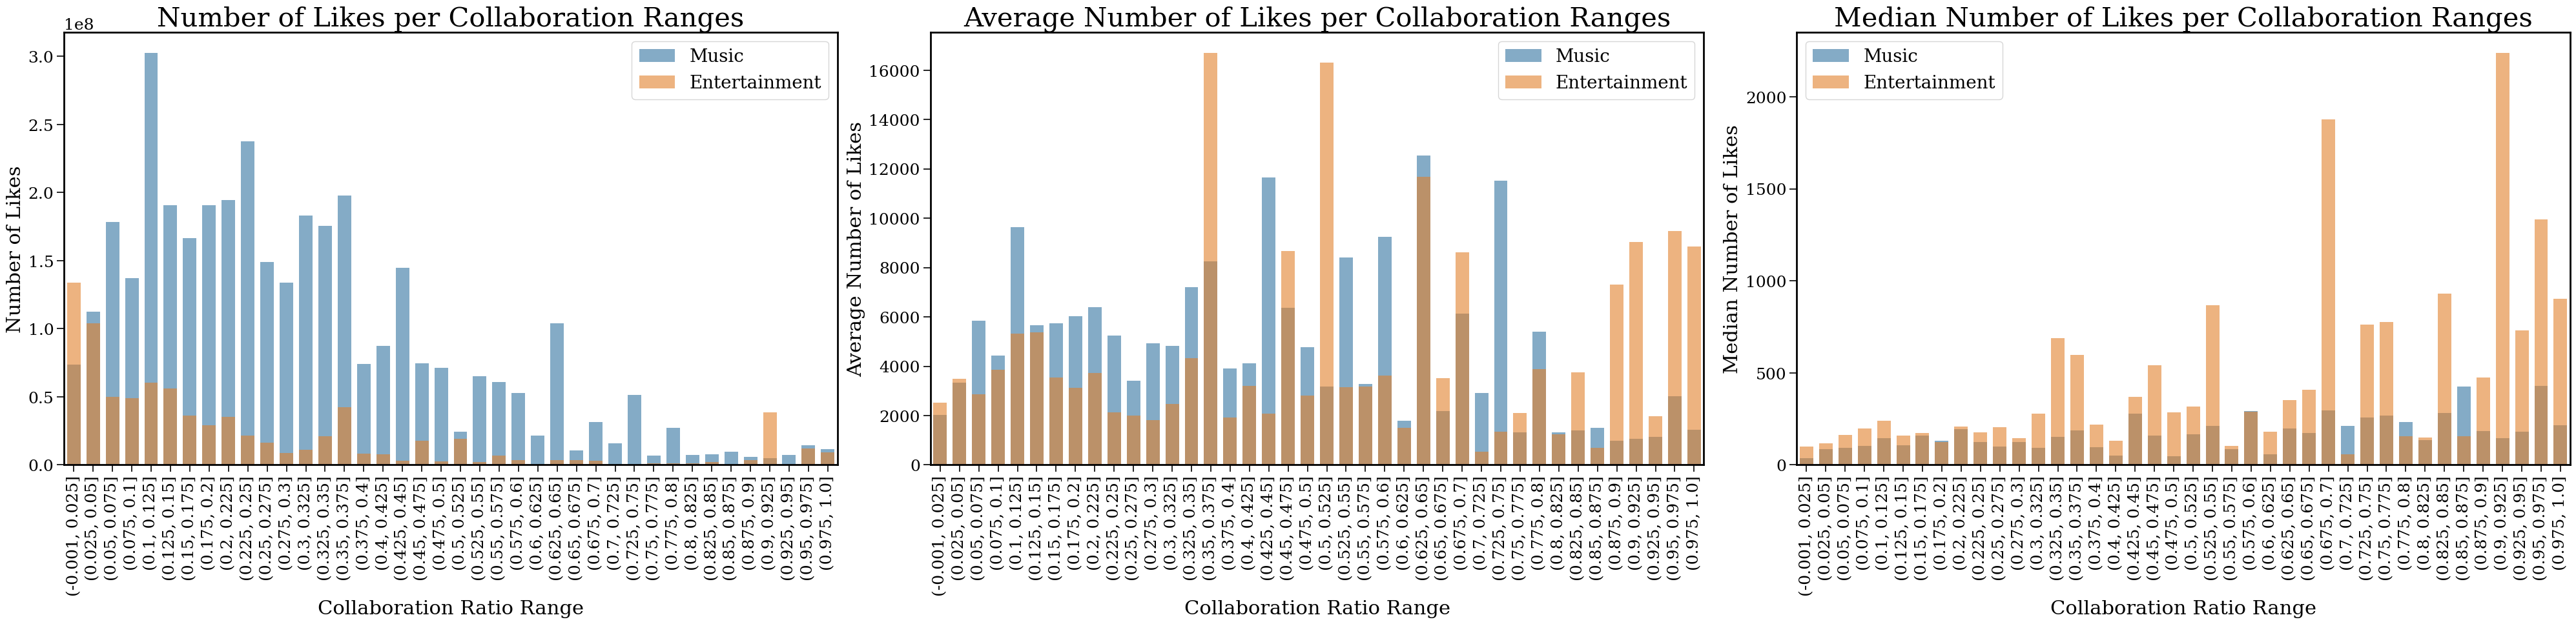

In [28]:
# Define plotting parameters for likes
metrics_likes = [("num_likes", "num_likes"), ("avg_likes", "avg_likes"), ("med_likes", "med_likes")]
titles_likes = ["Number of Likes per Collaboration Ranges", "Average Number of Likes per Collaboration Ranges", "Median Number of Likes per Collaboration Ranges"]
ylabels_likes = ["Number of Likes", "Average Number of Likes", "Median Number of Likes"]

# Plot the likes statistics vs. collaboration ratio range
data_utils.plot_collaboration_stats(stats_music, stats_entertainment, metrics_likes, titles_likes, ylabels_likes)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Some comments**: Comments are similar to those above.

**Take aways for likes**: Conclusions are similar to those obtained via the statistics on views. 

</div>

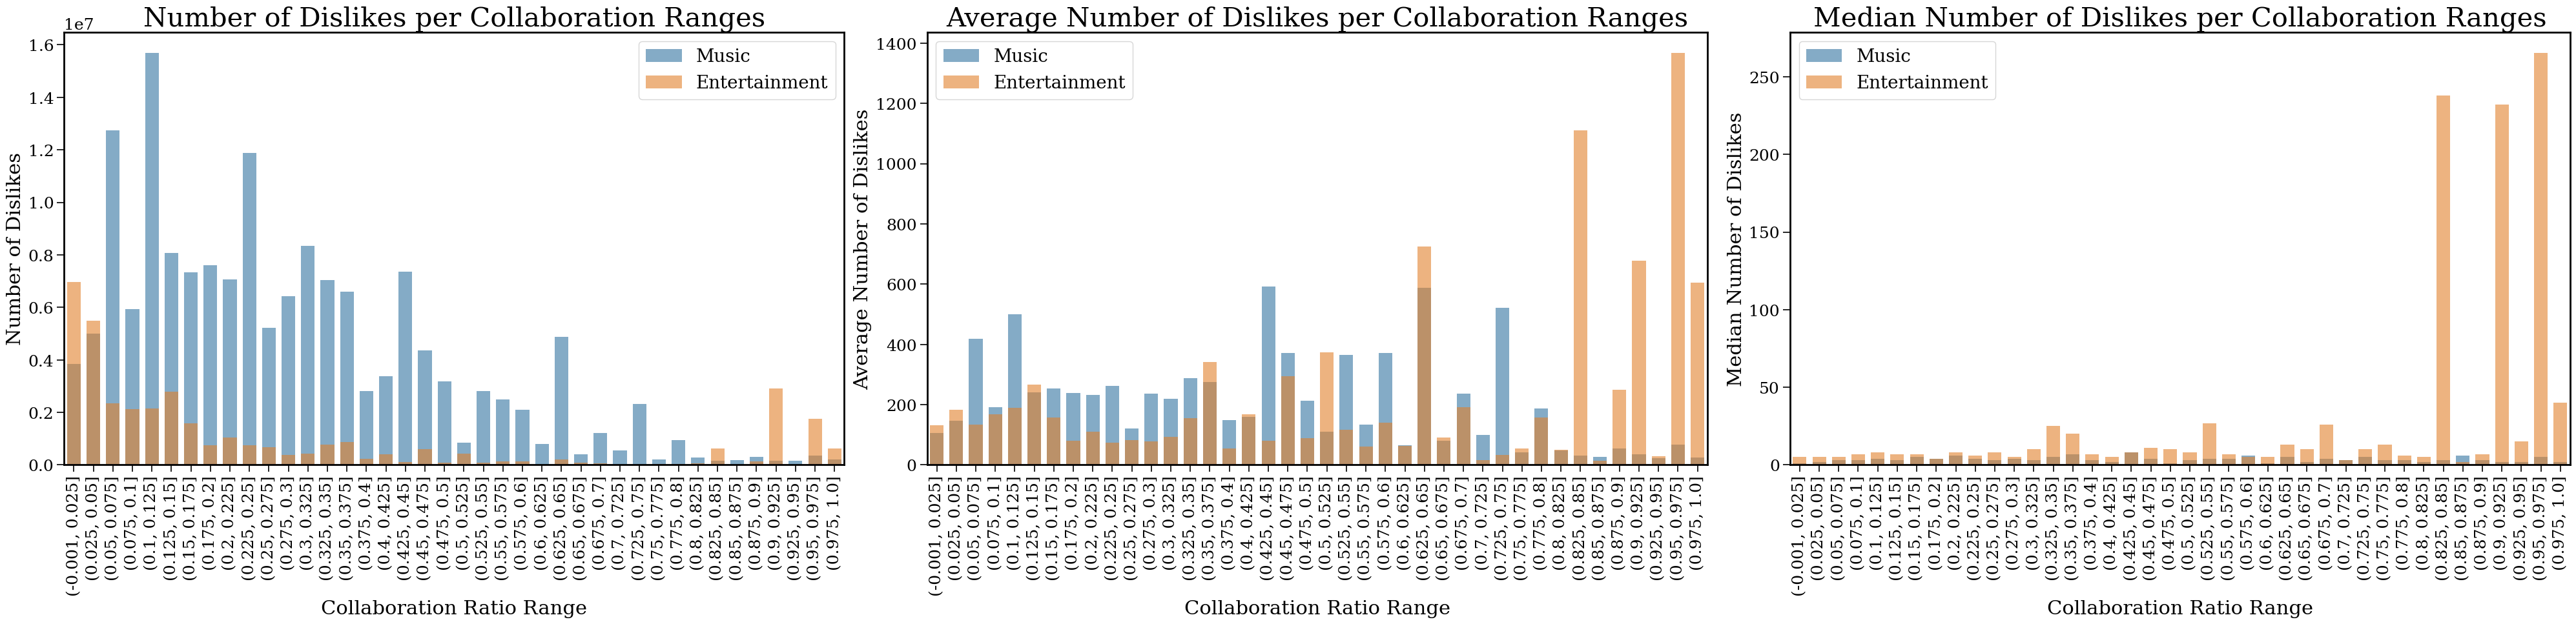

In [29]:
# Define plotting parameters for dislikes
metrics_dislikes = [("num_dislikes", "num_dislikes"), ("avg_dislikes", "avg_dislikes"), ("med_dislikes", "med_dislikes")]
titles_dislikes = ["Number of Dislikes per Collaboration Ranges", "Average Number of Dislikes per Collaboration Ranges", "Median Number of Dislikes per Collaboration Ranges"]
ylabels_dislikes = ["Number of Dislikes", "Average Number of Dislikes", "Median Number of Dislikes"]

# Plot the dislikes statistics vs. collaboration ratio range
data_utils.plot_collaboration_stats(stats_music, stats_entertainment, metrics_dislikes, titles_dislikes, ylabels_dislikes)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">


**Some comments**: Again similar to the two above. But this time, the difference in the median is even more clear. 

**Take aways for dislikes**: 
- Entertainment content is overall more engaging
- Entertainment benefits from more collaborations in positive and negative ways
- The median of dislikes for music is really low in general: this **maybe shows a difference in the behaviour of users** (more "passive" behaviour for Music and more "engaged" one for Entertainment).
- The large difference between the median and the mean hints to the fact that there are strong outliers in the Music category (same is true for Entertainment but to a lower extent). 

</div>

### Time Evolution of Collaborations

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

Here, we plot the evolution of the number of uploads for collaboration videos over time for each category as well as the "derivative" of this curve, i.e. the number of uploads per time unit (month, week, day). 

</div>

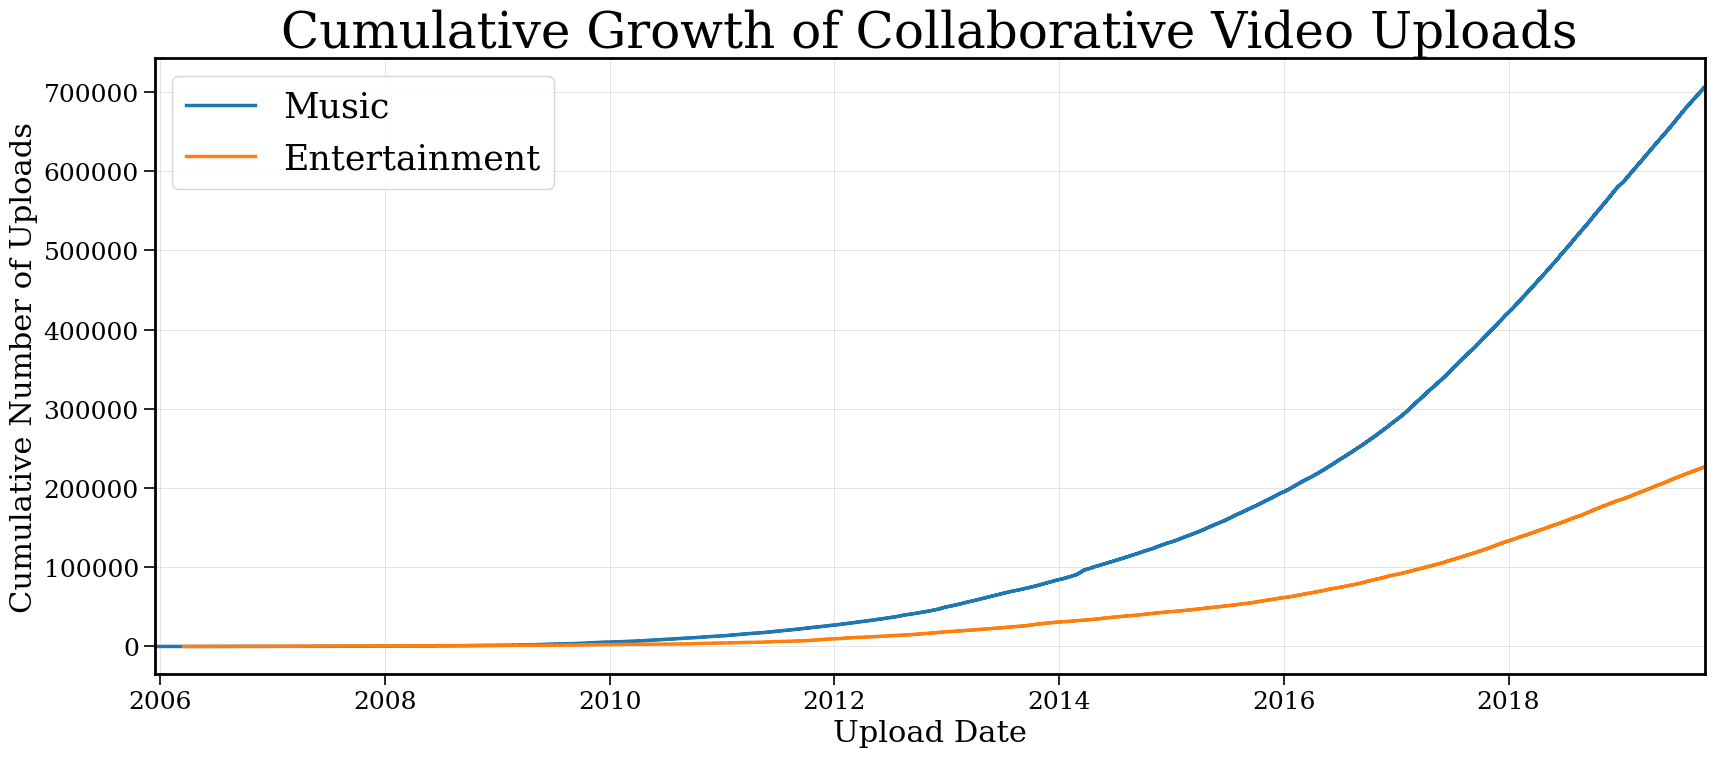

In [30]:
data_utils.get_upload_evolution(df_music, df_entertainment, cumulative=True)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Some comments**: 

For the cumulative growth (first plot): both curves exhibit a similar type of growth, with what looks to be an overall exponential trend in the cumulative number of collaborations over time. However, the curve for the Music category starts to grow earlier, indicating that collaborations in this category began earlier than those in the Entertainment category.


For the others, the number of uploads for collaboration videos is always higher for the Music category. There seem not to exist any periodic trend for both categories.
 - A remarkable peak is observed for the Music category in 2014.
</div>

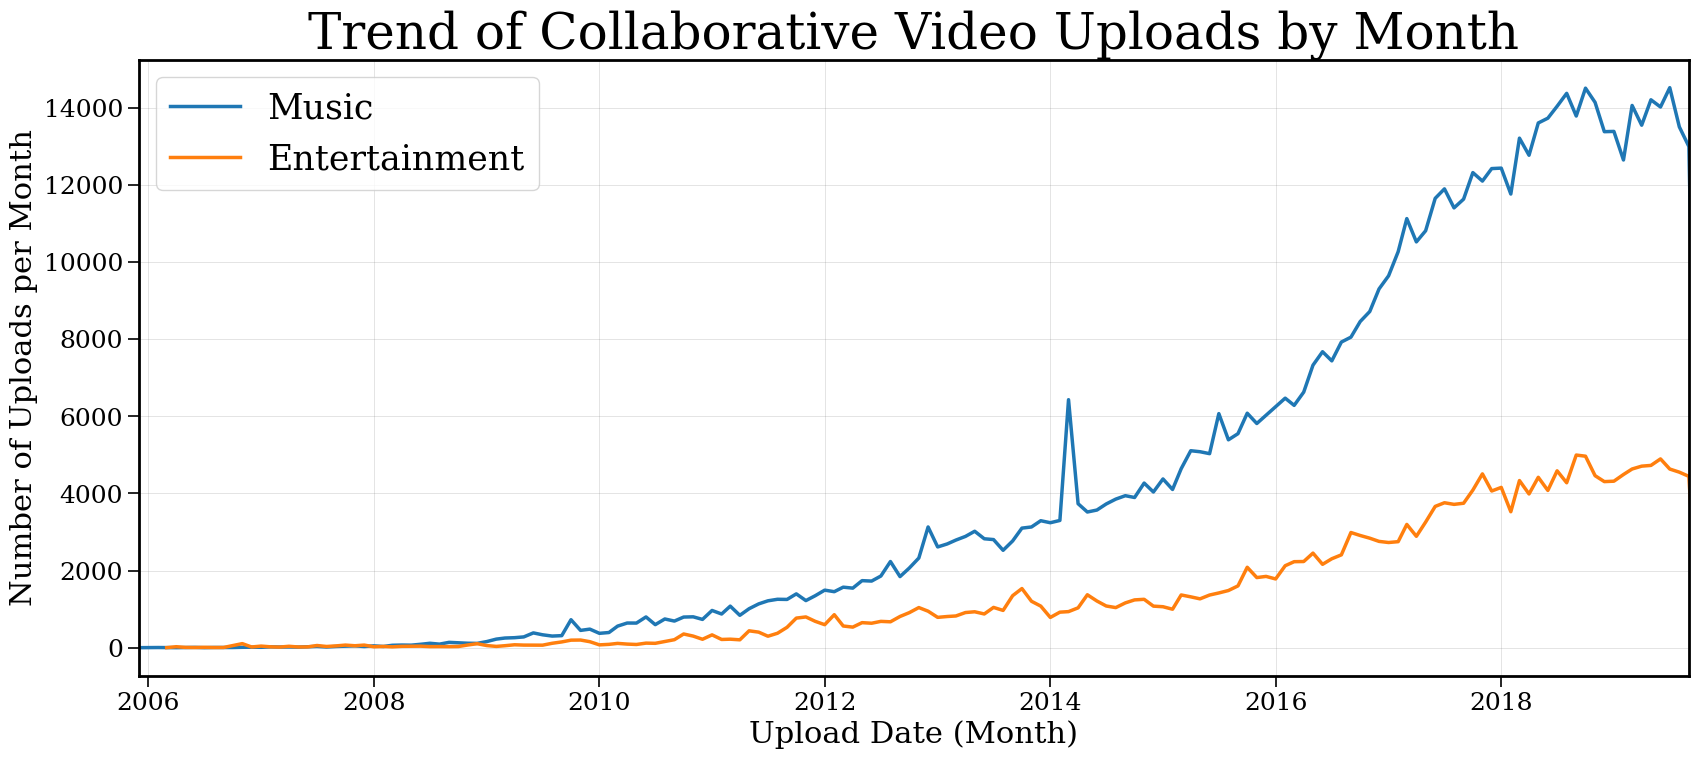

In [31]:
# Monthly Evolution
data_utils.get_upload_evolution(df_music, df_entertainment, period="M")

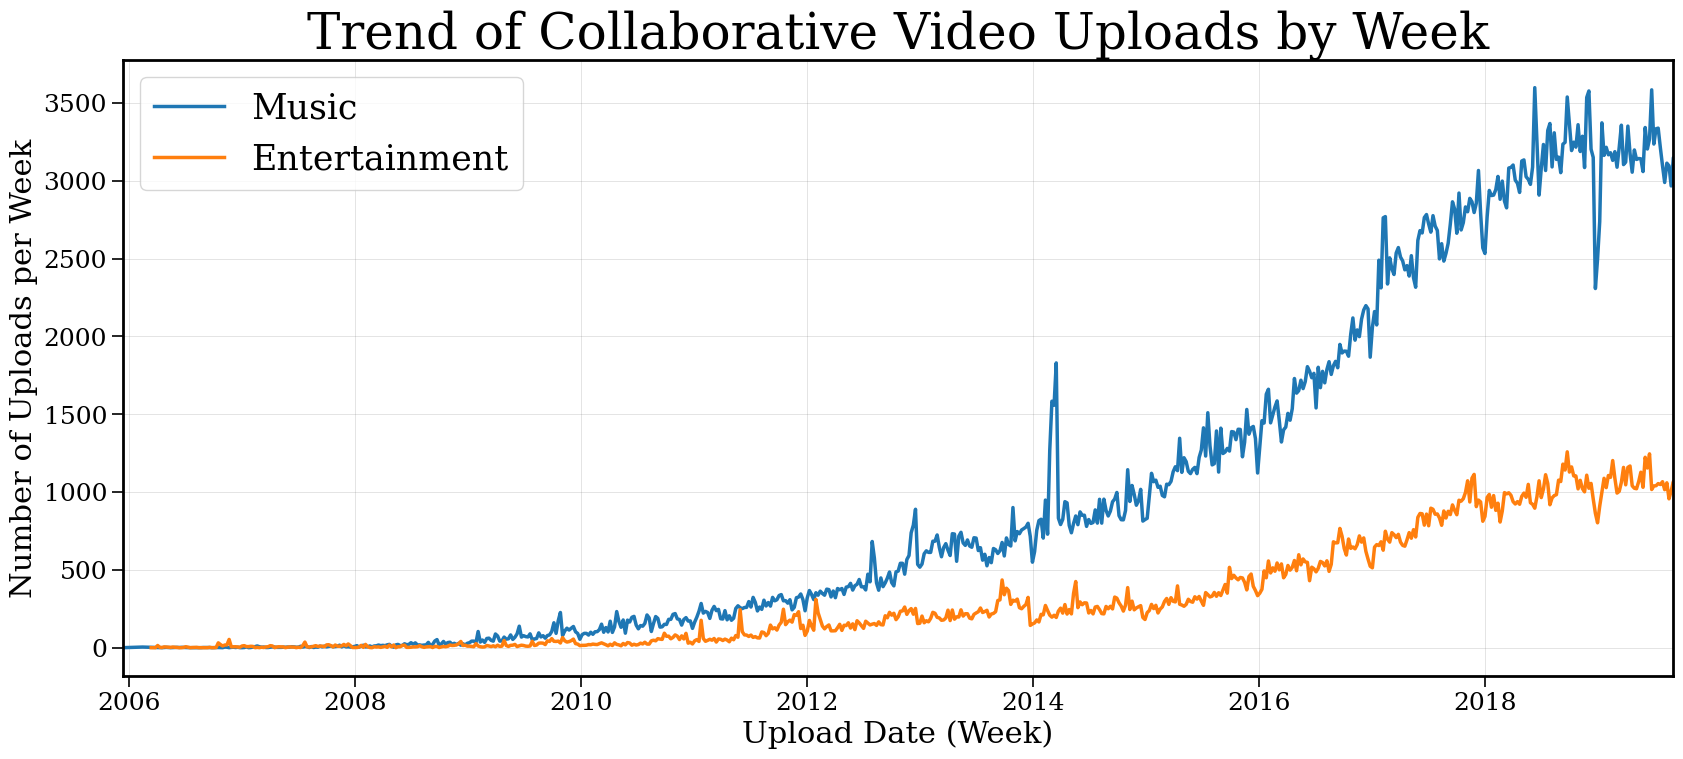

In [32]:
# Weekly Evolution
data_utils.get_upload_evolution(df_music, df_entertainment, period="W")

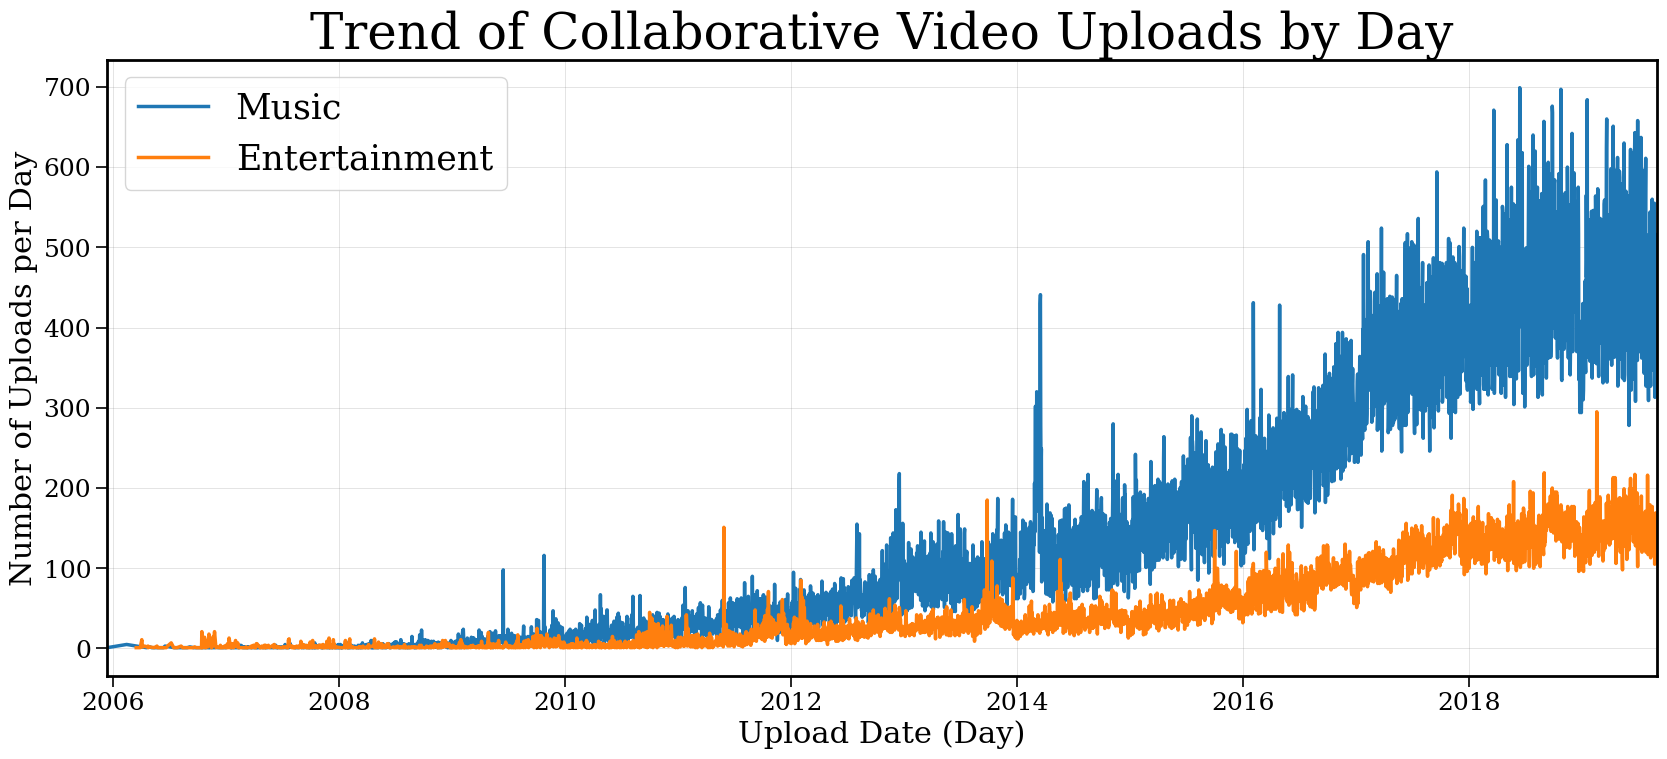

In [33]:
# Daily Evolution
data_utils.get_upload_evolution(df_music, df_entertainment, period="D")

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Warning:** The following cell is really slow to run (~6 hours). Its works as follows: 

For each collaboration ratio ranges defined above: 
- Find the channels with a collaboration ratio in the range
- Collect the data for the videos made by these channels that are not collaborations as well as the data for the videos that are collaborations
- Save the results in a new file

</div>


In [34]:
# This takes a long time to run
# input_path = "data/yt_metadata_filtered.jsonl.gz"
# data_utils.process_by_collaboration_ranges(df, input_path, verbose=True)

### Evolution of Collaboration Video and Non-Collaboration Video Uploads

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

Here, we plot the evolution of the number of uploads for collaboration and non-collaboration videos over time for each category, given a **fixed collaboration ratio range**.

</div>

In [35]:
lower = "0.500"
upper = "0.525"
input_path = f"data/collab_ratio_ranges/collaborations_{lower}_{upper}.jsonl.gz"

# Load the data
df_collab_ratio_range = pd.read_json(input_path, lines=True, compression='gzip')

# Add the number of videos per channel_id
df_collab_ratio_range = pd.merge(df_collab_ratio_range, df_video_counts, on='channel_id', how='left')

# Add the channel names and other information (same as above)
df_collab_ratio_range = pd.merge(df_collab_ratio_range, df_channels, on='channel_id', how='left')

# Add the number of collaborations per channel_id
df_collab_count = df_collaborations.groupby('channel_id')['collaborations_count'].mean().reset_index()
df_collab_ratio_range = pd.merge(df_collab_ratio_range, df_collab_count, on='channel_id', how='inner')

# Tag the collaborations, set non-collaborations to 0
df_tag_collaborations = pd.DataFrame(df_collaborations["title"].copy())
df_tag_collaborations["collaboration"] = 1
df_collab_ratio_range = pd.merge(df_collab_ratio_range, df_tag_collaborations, on='title', how='left')
df_collab_ratio_range["collaboration"] = df_collab_ratio_range["collaboration"].fillna(0)

# Reorder the columns
new_order = ['name_cc', 'title', 'collaboration', 'view_count', 'like_count', 'dislike_count', 'description',
             'tags', 'upload_date', 'subscribers_cc','video_count', 'collaborations_count', 'channel_id', 'categories']
df_collab_ratio_range = df_collab_ratio_range[new_order]

In [36]:
# Sample a channel_id
channel_id1 = df_collab_ratio_range["channel_id"].sample(1).values[0]

# Get the channel_name
channel_name1 = df_collab_ratio_range[df_collab_ratio_range["channel_id"] == channel_id1]["name_cc"].values[0]

# Get the channel category (majority)
channel_category1 = df_collab_ratio_range[df_collab_ratio_range["channel_id"] == channel_id1]["categories"].value_counts().index[0]

# Get the data for the channel_id, sort by upload_date, and compute the cumulative number of videos
df_channel_id1 = df_collab_ratio_range[df_collab_ratio_range["channel_id"] == channel_id1].copy()
df_channel_id1["upload_date"] = pd.to_datetime(df_channel_id1["upload_date"])
df_channel_id1 = df_channel_id1.sort_values("upload_date").reset_index(drop=True)
df_channel_id1["cumulative_collaborations"] = df_channel_id1["collaboration"].cumsum()
df_channel_id1["cumulative"] = range(1, df_channel_id1.shape[0] + 1)
df_channel_id1["cumulative_non_collaborations"] = df_channel_id1["cumulative"] - df_channel_id1["cumulative_collaborations"]

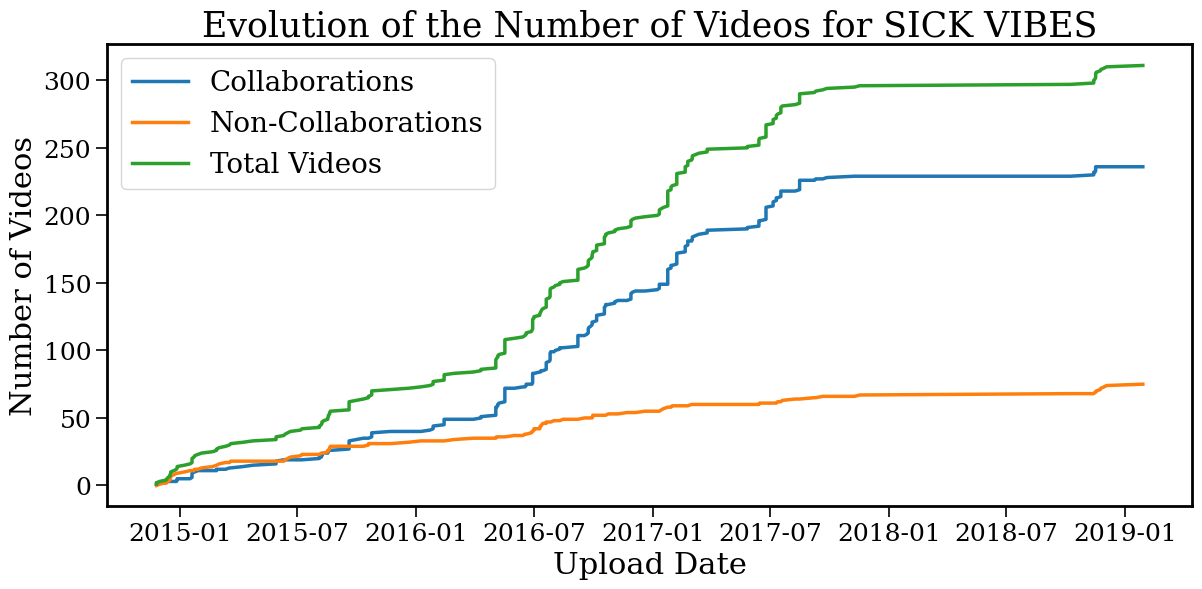

In [37]:
# Plot the evolution of the number of uploads for collaboration and non-collaboration videos over time for the sampled channel_id
plt.figure(figsize=(14, 6))
plt.plot(df_channel_id1["upload_date"], df_channel_id1["cumulative_collaborations"], label="Collaborations")
plt.plot(df_channel_id1["upload_date"], df_channel_id1["cumulative_non_collaborations"], label="Non-Collaborations")
plt.plot(df_channel_id1["upload_date"], df_channel_id1["cumulative"], label="Total Videos")
plt.xlabel("Upload Date")
plt.ylabel("Number of Videos")
plt.title(f"Evolution of the Number of Videos for {channel_name1}", fontsize=25)
plt.legend()
plt.show()

### Are there "collaboration turning points"? 

An idea would be to try to detect "turning points" in the collaboration strategy of a channel. 

By defining potential turning points as follows:
- A collaboration video 
- A video that has a number of views/likes that is significantly higher than the previous videos (e.g. 10x the average number of views/likes) 

We could then look at the channel evolution before and after the turning point over time and compare different quantities: 
- The rate of the number of collaboration videos: if more collaborations are made after the turning point, this could indicate that collaborations have been viewed as successful. 
- The rate of the number of videos
- The rate of the number of views/likes/dislikes 

## Idées additionnelles: 

- Pour les créateurs faisant des vidéos dans les deux catégories: définir dans un premier temps la catégorie principale de la chaîne (celle avec le plus de vidéos) et ensuite comparer les statistiques pour les collaborations dans cette catégorie avec celles pour les collaborations dans l'autre catégorie. Est-ce que les vidéos issues de la catégorie non dominante sont moins populaires? Plus populaires? 

- Plot les quantiles en plus de la médiane pour les statistiques sur les vues, likes et dislikes. Peut-être observer que pour la musique, ce sont vraiment les top créateurs qui font la différence. 

- Pour une personne qui fait des collaborations dans une catégorie, est-ce que la diversité de contenu permet d'attirer plus de personnes? 

- Regarder le nombre de likes par vidéo en fonction du temps pour une range de collaboration ratio: est-ce que les vidéos collaboratives qui ont eu un grand succès ont eu une influence sur la suite de la chaîne, i.e. est-ce que les vidéos suivant cette vidéo populaire ont été collaboratives également?  

## Is there a correlation between the number of collaborations and a channel success? 

<div style="background-color: #FFC0CB; border-left:3px solid red; padding: 10px; border-radius: 5px;">

- Corrélation entre chaîne plus connue et les collaborations. Est-ce qu'une chaîne qui fait souvent des collaborations également plus généralement connues ?

</div>

## Est-ce que les vidéos collaboratives génèrent en moyenne plus d'engagement?

<div style="background-color: #FFC0CB; border-left:3px solid red; padding: 10px; border-radius: 5px;">

Pour chaque chaîne avec un ratio de collaboration fixé, on pourrait comparer les statistiques obtenues sur les vidéos non collaboratives et celles obtenues pour les vidéos collaboratives. Puis comparer.  

</div>

## Y a-t-il une différence entre les chaînes spécialisées sur une catégorie par rapport à celles qui produisent les deux types de contenus ?

Pour les créateurs qui ont différentes vidéos classées dans les deux catégories 

# Classification using a Zero-Shot Model

In [38]:
# from transformers import pipeline
# 
# def is_significant(collab_score, non_collab_score, threshold=0.1):
#     """
#     Check if the difference between two scores is significant.
# 
#     Args:
#         collab_score (float): Score for the collaboration label.
#         non_collab_score (float): Score for the non-collaboration label.
#         threshold (float): Minimum difference to consider the scores significant.
# 
#     Returns:
#         bool: True if the scores are significant, False otherwise.
#     """
#     return abs(collab_score - non_collab_score) > threshold
# 
# 
# MODEL_PATH = 'src/models/zero-shot-classification'
# 
# # Load the zero-shot classification model
# classifier = pipeline("src/models/zero-shot-classification", model="facebook/bart-large-mnli")
# 
# # Save the model to disk
# model_path = "src/models/zero-shot-classification"
# classifier.save_pretrained(model_path)
# 
# # Labels for the zero-shot classification model
# music_collab_labels = ['multiple artists']
# music_non_collab_labels = ['a single artist']
# music_labels = music_collab_labels + music_non_collab_labels
# 
# # Hypothesis template for the zero-shot classification model
# music_hypothesis_template = "This music is with {}."
# 
# texts = ["Radiohead live at Glastonbury 2003",
#          "The Beatles - Hey Jude", 
#          "Best of Debussy",
#          "HAYATO SUMINO – third round (18th Chopin Competition, Warsaw)",
#          "LL COOL J - Murdergram Deux ft. Eminem", 
#          "Eminem - Love The Way You Lie ft. Rihanna"
#          ]
# 
# for text in texts:
#     result = classifier(
#         text,
#         candidate_labels=music_labels,
#         hypothesis_template=music_hypothesis_template,
#         multi_label=False,
#     )
# 
#     # Extract scores for collaboration and non-collaboration labels
#     collab_scores = np.array([score for label, score in zip(result['labels'], result['scores']) if label in music_collab_labels])
#     non_collab_scores = np.array([score for label, score in zip(result['labels'], result['scores']) if label in music_non_collab_labels])
# 
#     total_collab_score = collab_scores.sum()
#     total_non_collab_score = non_collab_scores.sum()
# 
#     # Check if the scores are significant
#     if is_significant(total_collab_score, total_non_collab_score, threshold=0.5):
#         # Décider de la catégorie basée sur le score maximal
#         if total_collab_score > total_non_collab_score:
#             prediction = "Collaborative"
#         else:
#             prediction = "Non-Collaborative"
#     else:
#         continue
# 
#     print(f"Text: {text}. "
#           f"\n    - Predicted category: {prediction}, "
#           f"\n    - collab_score: {total_collab_score}, "
#           f"\n    - non_collab_score: {total_non_collab_score}")